### moers_bins_v04.ipynb



The content of this Notebook is based on [this](https://automating-gis-processes.github.io/2017/course-info/course-info.html) course from the University of Helsinki.

And the [this](https://mlrose.readthedocs.io/en/stable/source/tutorial2.html) tutorial for solving the Travelling Salesman Problem with `mlrose`.

In [1]:
import mlrose
import numpy as np
import geopandas as gpd
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from geopandas.tools import geocode
from itertools import chain
from shapely.geometry import LineString, Point

C:\Users\sarah\Anaconda3\envs\geo_py_37\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


### Import street network of Moers from OpenStreetMaps 
#### network_type='bike' or 'drive' or 'walk'

In [2]:
place_name = "Moers, Germany"
graph = ox.graph_from_place(place_name, network_type='drive')
#ox.save_load.save_graph_shapefile(graph, "Moers", folder="Data/")

In [3]:
#ox.save_load.save_as_osm(graph, "Moers", folder="Data/")

In [4]:
nodes, edges = ox.graph_to_gdfs(graph, nodes=True, edges=True)

In [5]:
nodes.crs

'+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'

### Geocode the starting point (ENNI Betriebshof)

In [6]:
# Geocode addresses with Nominatim backend
start = geocode("Am Jostenhof 7-9, 47441 Moers, Germany", provider='nominatim')
start.crs

{'init': 'epsg:4326', 'no_defs': True}

### Import shapefile (created with QGIS) of bins in Moers

In [7]:
fp = "Data/bins_Moers.shp"
bins = gpd.read_file(fp)
bins.crs

{'init': 'epsg:4326'}

### Reproject the points to the same projection as the road network

In [8]:
proj_text = str.format(edges.crs)

# Reproject the geometries by replacing the values with projected ones
bins = bins.to_crs(proj_text)
#end_point = points_proj.iloc[np.argmin(distances)]
#data_bin_proj.crs = CRS("EPSG:32632")
start = start.to_crs(proj_text)

C:\Users\sarah\Anaconda3\envs\geo_py_37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\Users\sarah\Anaconda3\envs\geo_py_37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


### Reformat start point

In [9]:
start_point = start.geometry
start_xy = (start_point.y.item(), start_point.x.item())

### Sample 10 "full" bins

In [38]:
sample_bin = bins.sample(n=10)
sample_bin.head()

,Name,Latitude,Longitude,lfd# Nr#,Stadtteil,Anzahl_beh,ort,Straße,Art,Abfuhrtag,Woche-g-ug,Telefon,Zeitbedarf,geometry
539,Papierkorb 200000681,51.472961,6.623052,1678,None,1,Moers,None,Papierkorb,None,None,None,0.5,POINT (6.62305 51.47296)
330,Papierkorb 200000138,51.451071,6.627715,1469,None,1,Moers,None,Papierkorb,None,None,None,0.5,POINT (6.62772 51.45107)
988,Papierkorb 200000906,51.448680,6.664120,2127,None,1,Moers,None,Papierkorb,None,None,None,0.5,POINT (6.66412 51.44868)
491,Papierkorb 200000030,51.484873,6.613510,1630,None,1,Moers,None,Papierkorb,None,None,None,0.5,POINT (6.61351 51.48487)
251,Papierkorb 200001169,51.446713,6.614423,1390,None,1,Moers,None,Papierkorb,None,None,None,0.5,POINT (6.61442 51.44671)


In [39]:
sample_points = sample_bin.geometry

In [40]:
sample_points

539    POINT (6.62305 51.47296)
330    POINT (6.62772 51.45107)
988    POINT (6.66412 51.44868)
491    POINT (6.61351 51.48487)
251    POINT (6.61442 51.44671)
934    POINT (6.66215 51.41988)
682    POINT (6.65466 51.41899)
186    POINT (6.61277 51.44054)
15     POINT (6.58843 51.42187)
419    POINT (6.59449 51.47253)
Name: geometry, dtype: geometry

In [41]:
sample_xy = []

### Add start point to bin samples

In [42]:
sample_xy.append(start_xy)

In [43]:
sample_xy

[(51.4525429, 6.607198265428346)]

### Reformat points of "full" bins

In [44]:
for index in range(0,sample_points.count()):
    sample_xy.append((sample_points.iloc[index].y, sample_points.iloc[index].x))

In [45]:
print(sample_xy)

[(51.4525429, 6.607198265428346), (51.47296127, 6.623051651), (51.4510705, 6.627715426), (51.4486799, 6.664119875), (51.48487313, 6.613510363), (51.44671284, 6.614422565), (51.41988044, 6.662149793), (51.41898911, 6.654661819), (51.44053831, 6.612771833), (51.42186804, 6.588427769), (51.47252751, 6.594490819)]


#### Initialize fitness function object by using a list coordinates (sample_x_y)

In [46]:
fitness_coords = mlrose.TravellingSales(coords = sample_xy)

#### Define optimization problem object

In [47]:
problem_fit = mlrose.TSPOpt(length = len(sample_xy), fitness_fn = fitness_coords, maximize=False)

In [48]:
# Solve problem using the genetic algorithm
best_state, best_fitness, fitness_curve = mlrose.genetic_alg(problem_fit, mutation_prob = 0.2, max_attempts = 50, random_state = 2, curve = True)

print(best_state)
print(best_fitness)

[ 9  5  0  8 10  4  1  2  3  6  7]
0.29482737689229466


In [49]:
#print(fitness_curve)

### Calculate the network nodes that are closest to start and end point

In [50]:
orig_xy = sample_xy[best_state[0]]
target_xy = sample_xy[best_state[1]]

orig_node = ox.get_nearest_node(graph, orig_xy, method='euclidean')
target_node = ox.get_nearest_node(graph, target_xy, method='euclidean')

print(orig_node)
print(target_node)

528027568
204903884


In [51]:
route = []

In [52]:
#route = nx.shortest_path(G=graph, source=orig_node, target=target_node, weight='length')

In [53]:
#fig, ax = ox.plot_graph_route(graph, route, origin_point=orig_xy, destination_point=target_xy, show=False, close=False)

#sample_bin.plot(ax=ax, color='red', markersize=5)

#plt.tight_layout()

In [54]:
for index in range(0,sample_points.count()+1):
    
    if index == int(sample_points.count()):
        orig_xy = sample_xy[best_state[-1]]
        target_xy = sample_xy[best_state[0]]
        print("!!!")
        
    else:
    
        orig_xy = sample_xy[best_state[index]]
        target_xy = sample_xy[best_state[index+1]]
    
    orig_node = ox.get_nearest_node(graph, orig_xy, method='euclidean')
    target_node = ox.get_nearest_node(graph, target_xy, method='euclidean')
    
    #print(orig_node)
    #print(target_node)
    
    route_temp = nx.shortest_path(G=graph, source=orig_node, target=target_node, weight='length')
    print(route)
    route.append(route_temp)
    route_temp = []

[]
[[528027568, 528027578, 370153358, 1548016672, 1548016706, 1548016750, 1545014472, 1545014642, 35961855, 1964674384, 57582237, 35961854, 57582234, 1137581827, 87116860, 1137582055, 26111401, 1219295401, 1559488104, 204903898, 204903896, 204903884]]
[[528027568, 528027578, 370153358, 1548016672, 1548016706, 1548016750, 1545014472, 1545014642, 35961855, 1964674384, 57582237, 35961854, 57582234, 1137581827, 87116860, 1137582055, 26111401, 1219295401, 1559488104, 204903898, 204903896, 204903884], [204903884, 204903896, 204903907, 204903840, 204919361, 204903804, 204903923, 204903924, 1549405677, 1549405682, 26881444]]
[[528027568, 528027578, 370153358, 1548016672, 1548016706, 1548016750, 1545014472, 1545014642, 35961855, 1964674384, 57582237, 35961854, 57582234, 1137581827, 87116860, 1137582055, 26111401, 1219295401, 1559488104, 204903898, 204903896, 204903884], [204903884, 204903896, 204903907, 204903840, 204919361, 204903804, 204903923, 204903924, 1549405677, 1549405682, 26881444], [2

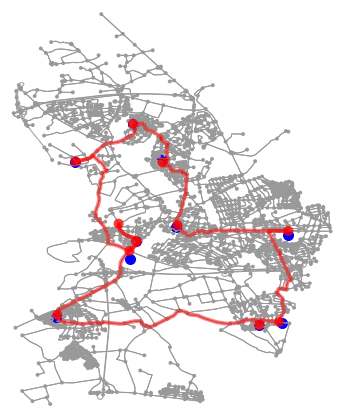

In [55]:
fig, ax = ox.plot_graph_routes(graph, route, save=True, show=False, close=False)

sample_bin.plot(ax=ax, color='blue', markersize=100)

plt.tight_layout()

### Combine the nodes of the route with information from the network

In [56]:
route_nodes = nodes.loc[list(chain(*route))]

In [57]:
print(route_nodes)

                    y         x       osmid highway  ref  \
528027568   51.422451  6.588885   528027568     NaN  NaN   
528027578   51.423234  6.588372   528027578     NaN  NaN   
370153358   51.423693  6.589543   370153358     NaN  NaN   
1548016672  51.424148  6.589087  1548016672     NaN  NaN   
1548016706  51.425244  6.591513  1548016706     NaN  NaN   
...               ...       ...         ...     ...  ...   
528032206   51.420595  6.589507   528032206     NaN  NaN   
528032205   51.420879  6.589447   528032205     NaN  NaN   
528032204   51.421162  6.589399   528032204     NaN  NaN   
528027581   51.421532  6.589348   528027581     NaN  NaN   
528027568   51.422451  6.588885   528027568     NaN  NaN   

                            geometry  
528027568   POINT (6.58889 51.42245)  
528027578   POINT (6.58837 51.42323)  
370153358   POINT (6.58954 51.42369)  
1548016672  POINT (6.58909 51.42415)  
1548016706  POINT (6.59151 51.42524)  
...                              ...  
528032

### Convert route into a linestring

In [58]:
route_line = LineString(list(route_nodes.geometry.values))
print(route_line)

LINESTRING (6.5888851 51.422451, 6.5883716 51.4232335, 6.5895431 51.4236929, 6.5890867 51.4241477, 6.5915131 51.4252437, 6.5942677 51.4266382, 6.5961838 51.4276061, 6.6006162 51.4298662, 6.6074521 51.433494, 6.6076236 51.4336075, 6.6088564 51.4347515, 6.6092064 51.4353258, 6.6093424 51.4356696, 6.6095369 51.4368028, 6.6095239 51.4374582, 6.6094889 51.4378725, 6.6124317 51.4433261, 6.6126091 51.4435013, 6.6161763 51.4465757, 6.6155345 51.4468482, 6.6149658 51.4470896, 6.6146183 51.4465216, 6.6146183 51.4465216, 6.6149658 51.4470896, 6.6144424 51.4473119, 6.612252 51.4480763, 6.6116623 51.4483004, 6.6106733 51.4488805, 6.6098575 51.4496182, 6.6095986 51.4499483, 6.6090601 51.4511341, 6.6092623 51.4511478, 6.6088813 51.4522316, 6.6088813 51.4522316, 6.6092623 51.4511478, 6.6090601 51.4511341, 6.6095986 51.4499483, 6.6098575 51.4496182, 6.6106733 51.4488805, 6.6116623 51.4483004, 6.612252 51.4480763, 6.6144424 51.4473119, 6.6149658 51.4470896, 6.6155345 51.4468482, 6.6161763 51.4465757, 6.

### Create a GeoDataFrame from the linestring

In [59]:
route_geom = gpd.GeoDataFrame(crs=edges.crs)

route_geom['geometry'] = None
route_geom['osmids'] = None

In [60]:
route_geom.loc[0, 'geometry'] = route_line

route_geom.loc[0, 'osmids'] = str(list(route_nodes['osmid'].values))

### Plot the route s dashed line onto the nodes and edges of the network

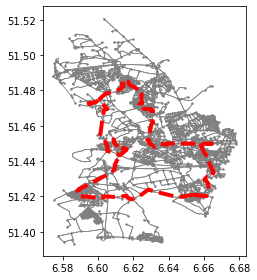

In [61]:
fig, ax = plt.subplots()
edges.plot(ax=ax, linewidth=0.75, color='gray')
nodes.plot(ax=ax, markersize=2, color='gray')
route_geom.plot(ax=ax, linewidth=4, linestyle='--', color='red')
plt.tight_layout()

### Prepare the saving of shapefiles

In [62]:
place_name_out = place_name.replace(' ', '_').replace(',','')
#streets_out = r"Data/%s_streets.shp" % place_name_out
route_out = r"Data/Route_%s.shp" % place_name_out

In [63]:
#edges.to_file(streets_out)

In [64]:
route_geom.to_file(route_out)

In [65]:
route

[[528027568,
  528027578,
  370153358,
  1548016672,
  1548016706,
  1548016750,
  1545014472,
  1545014642,
  35961855,
  1964674384,
  57582237,
  35961854,
  57582234,
  1137581827,
  87116860,
  1137582055,
  26111401,
  1219295401,
  1559488104,
  204903898,
  204903896,
  204903884],
 [204903884,
  204903896,
  204903907,
  204903840,
  204919361,
  204903804,
  204903923,
  204903924,
  1549405677,
  1549405682,
  26881444],
 [26881444,
  1549405682,
  1549405677,
  204903924,
  204903923,
  204903804,
  204919361,
  204903840,
  204903907,
  204903896,
  204903898,
  1559488104,
  1219295401,
  26111401],
 [26111401,
  363762052,
  204903761,
  204903766,
  752214203,
  752214177,
  204903775,
  1204631685,
  3978578738,
  1204631750,
  28244011,
  28244019,
  28244036,
  1275933646,
  28244122,
  253167892,
  253168067,
  28244219,
  28245104,
  253165408,
  243497698,
  442641576,
  224720444],
 [224720444,
  442641577,
  442641576,
  243497698,
  253165408,
  253045699,
  25